# Function Renaming
## Dataset preparation

This notebook shows how function graphs extracted from a compiled code in assembly language, are imported into Networkx and PyTorch Geometric for later processing.

The code in assembler is processed by a disassembler program (IDA pro in that case), where a plugin creates a graph for each function. The graph consists in 2 txt files containing the information about nodes, edges and attributes.

The goal of this task is to train a model that is able to classify a function in assembler language into several general purpose categories, for example networking, cryptography, control-loop, disk-read-write, computation.

**Topics to take care of:**
- multi-label+multi-class vs only multi-class
- dataset gathering sources:
    - libc
    - linux source code
    - cryptographic libraries
    - opensource web servers source code
    - reversed malware
    - packers/crypters
    - github search for some crypto/network libraries usage and export just the function using it(or 2-3 upper layers)
- we don't need opensource, just compiled code..
- source code could also be used...
- crypto libraries vs code that uses them
- polymorphism applied to do data augmentation

**Notebook index**:
- importing the graph into Nx and drawing it
- importing the graph into PyTorch geometric
- importing several graphs and training a toy model
    

## Original data

The original data consists of disassembly listings of code in assembler. The focus is on functions/subroutines, for each of them a plugin generates 2 txt files containing the information to generate the graph.

The assembler code listing:
![disassembler listing](./img/assembler01.png)


The assembler code in a block view:
![disassembler code blocks view](./img/assembler02.png)

Finally the plugin code is shown below:

In [ ]:
"""
	Goal:
		write a series of txt files to later be imported from Networkx library.
		
	structure of the files:
		1) Nodes:  mem-address = id?
				   features: 
					- type: instr, data_addr, register, immediate, funccall
					- contents: 
						- if instr  then string in a bagofwords-one-of-k-coding
						- if data_addr then ?
						- if register then name and address -> each transformed to int id
						- if immediate then value -> transformed to int id..?
						- if funccall -> funcaddr as int id
		2) edges: id auto increment integer
				 id of mem addr origin and id of mem addr destination
				 Directed edges
				 -> no attributes for the moment..
				 -> possible attributes:
					- type: to register, to data, to funccall, to immediate, to code
	

	REFACTOR TASKS:
		- file ini in a function
		- organize node and edge saving with a single method for each (according to networkx or PyG)
			- PYG format
				- node feature file: node id, feat1, feat2, ..
				- edge feature file: edge id, feat1, feat2, feat3,...
				- edge_index file: source node, destination node (later must be converted
			- Networkx format:
				- edge list: 1 2 ('weight':7, 'color': green, ...)
					- direct import into Networkx
				- node features file:  node id { 'feat1_name': feat1_val, ...}
					- manually add those features into the nodes once imported from edge_list
"""
from idaapi import *
import os
import datetime


class codeNode():
	def __init__(self, memaddr, type, content, fd_nodes=None, fd_edges=None):
		
		
		self.memaddr = memaddr
		self.type = type 
		self.content = content
		self.fd_nodes = fd_nodes
		self.fd_edges = fd_edges
		#Message("init: %s  %s  %s\n" % (self.memaddr, self.type, self.content))
	
	def saveNode(self, results_dict):
		global autoid
		#Message("before save:  %s  %s  %s\n" % (self.memaddr, self.type, self.content))
		
		if self.memaddr == '0' and self.type == 'register':
			self.memaddr = 'r' + self.content
		elif self.memaddr == '0' and self.type == 'immediate':
			self.memaddr = 'im' + self.content
		elif self.memaddr == '0' and self.type == 'memory':
			self.memaddr = 'm' + self.content
		elif self.memaddr == '0' and self.type == 'displacement':
			self.memaddr = 'd' + self.content
		elif self.memaddr == '0' and self.type == 'phrase':
			self.memaddr = 'p' + self.content
		elif self.memaddr == '0':
			autoid+=1
			self.memaddr = '_' + str(autoid)
			#Message(" memaddrr %s and autoid %d\n" % (self.memaddr,autoid))
			
		# to avoid overwriting, first verify not in dict
		if self.memaddr not in results_dict['nodes'].keys():
			results_dict['nodes'][self.memaddr] = {
				'memaddr' : self.memaddr,
				'type' : self.type,
				'content': self.content
			}
		else:
			# if already there, then study how to modify it
			# don't modify type, memaddr 
			# maybe can append data to content...
			if results_dict['nodes'][self.memaddr]['type'] != self.type and \
			    self.type == 'instr':
				results_dict['nodes'][self.memaddr]['type']=  self.type	
				results_dict['nodes'][self.memaddr]['content']= self.content
			elif  results_dict['nodes'][self.memaddr]['type'] != self.type and \
			    results_dict['nodes'][self.memaddr]['type'] == 'instr':
				pass
			elif results_dict['nodes'][self.memaddr]['type'] == 'unknown' and \
			    self.type == 'func':
				results_dict['nodes'][self.memaddr]['type']=  self.type	
				results_dict['nodes'][self.memaddr]['content']= self.content
			elif  results_dict['nodes'][self.memaddr]['type'] != self.type and \
			    results_dict['nodes'][self.memaddr]['type'] != 'instr':
				results_dict['nodes'][self.memaddr]['type']+= "; "  + self.type
			
			elif results_dict['nodes'][self.memaddr]['content'] != self.content:
				results_dict['nodes'][self.memaddr]['content']+= "; "  + self.content
		
		
		# will be written to disk at the end of the writeGraph function
		
		
		#self.fd_nodes.write('%s {"type": "%s", "content": "%s"}\n' % (self.memaddr, self.type, self.content))
		#Message("save:  %s  %s  %s\n" % (self.memaddr, self.type, self.content))
		
	def saveEdge(self, destination, results_dict):
		
		edgeid = self.memaddr +"-"+ destination.memaddr
		if edgeid not in results_dict['edges'].keys():
			results_dict['edges'][edgeid] = {
				'source': self.memaddr,
				'dest': destination.memaddr,
				'type': '{ "type": "'+destination.type+'" }'
			}
		
		#self.fd_edges.write('%s %s {"type": "%s" }\n' % (self.memaddr, destination.memaddr, destination.type))
		#Message("saveEdge: %s  %s  %s -  %s %s %s\n" % (self.memaddr, self.type, self.content,destination.memaddr, destination.type, destination.content))
	

def initializeFolder():
	prefix = "C:\labs\IDA_pro_book\\" 
	prefix = "H:\IDA_pro_book\\"
	try:
		thedate = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S') 
		folder_name  = AskStr(prefix + "newprogram_"+thedate , "Folder to save files to?")
		# create folder
		os.mkdir(folder_name)
		return folder_name
	except:
		Message(" Error initializing folder!")
		return False

def initializeFiles(folder_name, func):
	try:
		func = get_func(GetFunctionAttr(f, FUNCATTR_START))
		fname = Name(func.startEA)
		
		# initialize files 
		fd_nodes = open(folder_name + "/"+fname+"_nodes.txt", "w")
		fd_edges = open(folder_name + "/"+fname+"_edges.txt", "w")

		return fd_nodes, fd_edges
		
	except:
		Message(" Error initializing files at %s" % folder_name)
		return None, None
		

def instrToStr(instr):
	"""
		Receives a memaddr corresponding to an instruction
		It decodes the instruction and returns its mnemonic
	"""
	instr = DecodeInstruction(instr)
	if instr is not None:
		return instr.get_canon_mnem()
	else:
		return None
			
def processXrefFrom(f, xref, i, fd_nodes, fd_edges):
	global results_dict
	# save the caddr as a node (duplicates can exist)
	xref_node = codeNode(str(xref.to), 
						  type="instr", 
						  content=instrToStr(xref.to),
						  fd_nodes = fd_nodes,
						  fd_edges = fd_edges)
		
	#verify = False
	#if xref_node.content is not None and   xref_node.content.find('ret') > -1:
	#	Message(" xref  %s type is %d %s  content: %s \n" % (xref_node.memaddr, xref.type,XrefTypeName(xref.type), xref_node.content) )
	#	verify = True
	
	#Message(" xref type is %d %s \n" % (xref.type,XrefTypeName(xref.type)) )
	if XrefTypeName(xref.type) == 'Ordinary_Flow':
		pass # the xref is instr, and you want to write the edge
	elif xref.type == fl_CF or xref.type == fl_JF :
		# jump or call far
		xref_node.type = "func"
		xref_node.content = Name(xref.to)
		xref_node.saveNode(results_dict)
		
	elif xref.type == fl_CN or xref.type == fl_JN or xref.type == fl_F:
		# jump/call near or ordinary flow
		# compute if it comes from outside the function
		# if it does -> change type to func
		# otherwise do nothing 
	
		# HOW TO COMPUTE: initial func instruction?
		func_start = GetFunctionAttr(f, FUNCATTR_START)
		
		# HOW TO COMPUTE: last func instruction?
		func_end = GetFunctionAttr(f, FUNCATTR_END)
		
		# comparison
		xref_start = GetFunctionAttr(xref.to, FUNCATTR_START)
		inside = xref_start >= func_start and xref_start <= func_end
		#inside = True
		#Message(" xref_start: %s func_start: %s  func_end: %s \n" % (xref_start, func_start, func_end))
		
		# decision making
		if inside:
			#pass # do nothing, don't even save the node as it will overwrite previous saved node
			# as later the edges are read, networkx will create this node. So it would be better to remove it from the results_dict
			xref_node = None
		else:
			#Message(" xref %s computed as xref to outside the function! \n" % xref_node.memaddr)
			xref_node.type = "func"
			xref_node.content =  Name(xref.to)
			xref_node.saveNode(results_dict)
			
	elif XrefTypeName(xref.type).find('Data_')>-1:
		xref_node = None
	#else:
	#	Message(" xref type is %d %s \n" % (xref.type,XrefTypeName(xref.type)) )

	#if verify:
	#	Message("  %s \n" % (xref_node) )
		
	return xref_node
			
def processOperand(f, op,i, fd_nodes, fd_edges, verify=False):
	"""
	o_void = 0
 	o_reg = 1
 	o_mem = 2
 	o_phrase = 3
 	o_displ = 4
 	o_imm = 5
 	o_far = 6
 	o_near = 7
 	o_idpspec0 = 8
 	o_idpspec1 = 9
 	o_idpspec2 = 10
 	o_idpspec3 = 11
 	o_idpspec4 = 12
 	o_idpspec5 = 13
	
	"""
	global results_dict
	operand_node = codeNode(str(op.addr), 
						  type="data", 
						  content="",
						  fd_nodes = fd_nodes,
						  fd_edges = fd_edges)
						  
	#verify=False
	#if operand_node.memaddr == "4532035":
	if verify:
		#faddr = GetFunctionAttr(i, FUNCATTR_START)
		faddr = i
		print(idc.GetDisasm(faddr))
		operands = re.findall('\[(.*)\]', idc.GetDisasm(faddr))[0].split('+')
		print(operands)
		#print(str(op))
		print(op.phrase, op.reg, op.value)
		if op.type == o_phrase:
			#print(dir(op))
			pass
			#operands = re.findall('\[(.*)\]', idc.GetDisasm(faddr))[0].split('+')
		#for elem in dir(op):
		#	print(elem, op.__dict__.get(elem,''))
		#Message(" Operand-%s-(o_void=%s) %s %s \n" % (op.type, o_void, operand_node.content, op.value))
		#verify=True
						  
	#if op.type in [o_displ, o_phrase]:
	if op.type == o_void:
		return None
	elif op.type == o_displ:		
		# mem ref[BaseReg + index Reg + displ] 
		# mem ref[BaseReg + index Reg] 
		
		#f7maddr.write("%d\n" % (effectivemaddr))
		#f6datamaddr.write("%d,%s,%d\n" % (ea,theinstruction,effectivemaddr))
		
		# alternatively save as an immediate displ or base reg?
		#pass
		operand_node.type="displacement"
		operand_node.content=str(op.value)
	elif op.type == o_mem:
		operand_node.type="memory"
		operand_node.content=str(op.value)
	elif op.type == o_imm:
		operand_node.type="immediate"
		operand_node.content=str(op.value)
	elif op.type == o_reg:
		operand_node.type="register"
		operand_node.content=str(op.reg)
		#Message(" %s  %s %s %s\n" % (op.reg, op.phrase, op.value, op.addr))
	elif op.type == o_phrase:
		operand_node.type="phrase"
		#operand_node.content=str(op.phrase) # only prints immediates used in the register displacement
		instruc_str = idc.GetDisasm(i)
		phrases = instruc_str.split(',')
		#phrase = phrases[0] # not good then
		phrase = str(op.phrase)
		if len(phrases) > 1:
			phrase = phrases[1]
		else:
			# most of those cases are rep movsb, rep ...
			phrases = instruc_str.split(' ')
			if len(phrases) > 1:
				phrase = phrases[1]
			
			print(phrase, phrases)
		print(phrase)
		operand_node.content=phrase
	elif op.type == 7:
		operand_node.type="func"
		operand_func_start = GetFunctionAttr(op.addr, FUNCATTR_START)
		operand_node.content=Name(operand_func_start)
		# probably it's better to put the memaddr?
		#operand_node.content=operand_node.memaddr
		if verify:
			Message(" in type func")
	else:
		if verify:
			Message(" in type unknown")
		operand_node.type="unknown"
		operand_node.content=str(op.value)
	
	if verify:
		Message(" operand_node.content: %s, operand_node.type=%s \n" % (operand_node.content, operand_node.type))
	operand_node.saveNode(results_dict)
	return operand_node
		
def writeFuncGraphToDisk(results_dict, fd_nodes, fd_edges):
	
	for k,v in results_dict['nodes'].items():
		memaddr = v['memaddr']
		type = v['type']
		content = v['content']
		fd_nodes.write('%s {"type": "%s", "content": "%s"}\n' % (memaddr, type, content))
		
	for k,v in results_dict['edges'].items():
		"""
			{
				'source': self.memaddr,
				'dest': destination.memaddr,
				'type': '{ "type": "'+destination.type+'" }'
			}
		"""
		source = v['source']
		destination = v['dest']
		type = v['type']
		fd_edges.write('%s %s %s\n' % (source, destination, type))
	
def writeGraph(f,  fd_nodes, fd_edges):
	"""
	    This functions writes nodes and edges with the following format
	    Networkx format:
		- edge list: 1 2 ('weight':7, 'color': green, ...)
			- direct import into Networkx
		- node features file:  node id { 'feat1_name': feat1_val, ...}
			- manually add those features into the nodes once imported from edge_list
	
		now first using a dict, then writing to disk
	"""
	
	global results_dict
	results_dict = { 'nodes': {}, 'edges': {}}
	
	func = get_func(GetFunctionAttr(f, FUNCATTR_START))
	if not func is None:
		fname = Name(func.startEA)
		items = FuncItems(func.startEA)	
		
		for i in items:
			# prepare components of each node and edge list entry
			
			# save the origin caddr as a node (the instruction node)
			instr_node = codeNode(str(i), 
								  type="instr", 
								  content=instrToStr(i),
								  fd_nodes = fd_nodes,
								  fd_edges = fd_edges)
			verify = False
			if instr_node.memaddr == '4532035':
				pass
				#verify = True
			
			# save instr. operands as nodes and save edges too 
			instr = DecodeInstruction(i)
			operands = [instr_node.content]
			for op in instr.Operands:
				
				operand_node = processOperand(f, op,i, fd_nodes, fd_edges, verify)
				if operand_node is not None:
					instr_node.saveEdge(operand_node, results_dict)
					operands.append(operand_node.content)
			
			instr_node.content = " ".join(operands)
			instr_node.saveNode(results_dict)
				
			# save xrefs From i
			for xref in XrefsFrom(i,0):
				xref_node = processXrefFrom(f, xref,i, fd_nodes, fd_edges)
				if xref_node is not None:
					instr_node.saveEdge(xref_node, results_dict)
		
		#write func to disk
		writeFuncGraphToDisk(results_dict, fd_nodes, fd_edges)
			
			
folder_name = initializeFolder()
if not folder_name:
	Message("Error creating folder!")
	exit()

results_dict = {}
funcs = Functions()
for f in funcs:
	func = get_func(GetFunctionAttr(f, FUNCATTR_START))
	if not func is None: # and \
	   #Name(func.startEA)=='sub_452740':
		fd_nodes, fd_edges = initializeFiles(folder_name,f)
		autoid = 0
		writeGraph(f, fd_nodes, fd_edges)		
		fd_edges.close()
		fd_nodes.close()
			

			

				
# #      Flow types (combine with XREF_USER!):
# fl_CF   = 16              # Call Far
# fl_CN   = 17              # Call Near
# fl_JF   = 18              # jumpto Far
# fl_JN   = 19              # jumpto Near
# fl_F    = 21              # Ordinary flow

# XREF_USER = 32            # All user-specified xref types
                          # # must be combined with this bit
						  					  
# # Data reference types (combine with XREF_USER!):
# dr_O    = ida_xref.dr_O  # Offset
# dr_W    = ida_xref.dr_W  # Write
# dr_R    = ida_xref.dr_R  # Read
# dr_T    = ida_xref.dr_T  # Text (names in manual operands)
# dr_I    = ida_xref.dr_I  # Informational

# add_dref = ida_xref.add_dref
# del_dref = ida_xref.del_dref
# get_first_dref_from = ida_xref.get_first_dref_from
# get_next_dref_from = ida_xref.get_next_dref_from
# get_first_dref_to = ida_xref.get_first_dref_to
# get_next_dref_to = ida_xref.get_next_dref_to

## Networkx Visualization

We import the graphs into Networkx to visualize them and to verify the correctness

In [65]:
# import one function graph to nx and plot it
import networkx as nx
import json
import matplotlib.pyplot as plt

folder ='./plugin/newprogram_2019-04-04_13-22-02/'
filename = 'sub_DB2A93_edges.txt'
#filename = 'WINHTTP_452F00_edges.txt'
folder ='./tmp/functions/raw/graphs01/'
filename = 'sub_452740_edges.txt'
filename = 'Call_Decryption_Routine_45E320_edges.txt'


# read nodes, edges and  edge attributes
g = nx.read_edgelist(folder+filename)
# read node attributes
with open(folder+filename.replace('edges','nodes'),'r') as f:
    for line in f.readlines():
        tokens = line.split("{")
        nodeid = tokens[0][:-1]
        #print(nodeid)
        #print(tokens[1])
        attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
        print(nodeid)
        print(attr_dict)
        for k,v in attr_dict.items():
            print(k)
            try:
                g.node[nodeid][k] = v
            except:
                g.add_node(nodeid)
                g.node[nodeid][k] = v
                
            print(g.node[nodeid])

4580131
{'type': 'instr', 'content': 'push 4294967295'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'push 4294967295'}
4580334
{'type': 'instr', 'content': 'push 2'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'push 2'}
4580133
{'type': 'instr', 'content': 'push 4609448'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'push 4609448'}
4580332
{'type': 'instr', 'content': 'jmp 0'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'jmp 0'}
4580138
{'type': 'instr', 'content': 'push 4590092'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'push 4590092'}
4577792
{'type': 'unkown; func', 'content': '0'}
type
{'type': 'unkown; func'}
content
{'type': 'unkown; func', 'content': '0'}
4580507
{'type': 'instr', 'content': 'imul 0 0 100'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'imul 0 0 100'}
4580596
{'type': 'instr', 'content': 'mov 0 1'}
type
{'type': 'instr'}
content
{'type': 'instr', 'content': 'mov 0 1'}

In [66]:
i=0
for n1, n2, attr in g.edges(data=True): # unpacking
    print(n1, n2, attr) 
    i+=1
    #if i>3: break


4580256 r1 {'type': 'register'}
4580256 4580261 {'type': 'instr'}
4580256 im3756743572 {'type': 'immediate'}
4580256 4580253 {'type': 'instr'}
r1 4580345 {'type': 'register'}
r1 4580383 {'type': 'register'}
r1 4580483 {'type': 'register'}
r1 4580299 {'type': 'register'}
r1 4580202 {'type': 'register'}
r1 4580244 {'type': 'register'}
r1 4580388 {'type': 'register'}
r1 4580520 {'type': 'register'}
r1 4580478 {'type': 'register'}
r1 4580617 {'type': 'register'}
r1 4580490 {'type': 'register'}
r1 4580627 {'type': 'register'}
r1 4580451 {'type': 'register'}
r1 4580396 {'type': 'register'}
r1 4580376 {'type': 'register'}
r1 4580614 {'type': 'register'}
r1 4580224 {'type': 'register'}
r1 4580457 {'type': 'register'}
r1 4580386 {'type': 'register'}
r1 4580230 {'type': 'register'}
r1 4580517 {'type': 'register'}
r1 4580488 {'type': 'register'}
r1 4580316 {'type': 'register'}
r1 4580342 {'type': 'register'}
r1 4580385 {'type': 'register'}
r1 4580467 {'type': 'register'}
r1 4580471 {'type': 'regi

In [67]:
i=0
for n in g.nodes(data=True):
    print(n)
    i+=1
    #if i>100: break

('4580256', {'type': 'instr', 'content': 'mov 1 3756743572'})
('r1', {'type': 'register', 'content': '1'})
('4580194', {'type': 'instr', 'content': 'mov 0 6'})
('r6', {'type': 'register', 'content': '6'})
('4580438', {'type': 'instr', 'content': 'mov 0 3'})
('4580441', {'type': 'instr', 'content': 'mov 6 0'})
('4580150', {'type': 'instr', 'content': 'mov 0 4'})
('m0', {'type': 'memory', 'content': '0'})
('4580269', {'type': 'instr', 'content': 'mov 0 0'})
('4580275', {'type': 'instr', 'content': 'mov 7 3'})
('4580605', {'type': 'instr', 'content': 'mov 0 4294967295'})
('4580612', {'type': 'instr', 'content': 'xor 0 0'})
('4580558', {'type': 'instr', 'content': 'inc 3'})
('4580559', {'type': 'instr', 'content': 'mov 0 3'})
('4580149', {'type': 'instr', 'content': 'push 0'})
('4580213', {'type': 'instr', 'content': 'mov 0 0'})
('r0', {'type': 'register', 'content': '0'})
('4580157', {'type': 'instr', 'content': 'sub 4 156'})
('4580163', {'type': 'instr', 'content': 'mov 0 0'})
('4580138'

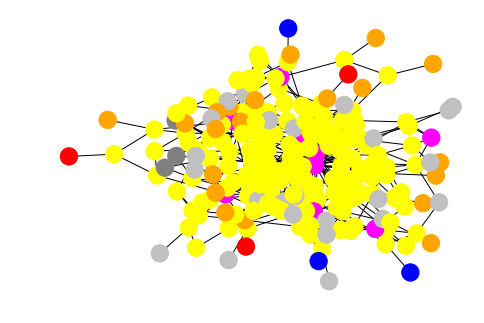

In [68]:
# color plot
attrs={}
palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]
types =['instr','func','immediate','memory','register',
        'displacement','phrase','unknown']

for node in g.nodes():
    if 'type' in g.node[node].keys():
        if g.node[node]['type'] in types:
            i = types.index(g.node[node]['type'])
        else:
            i=len(types)-1
            for j in types:
                if g.node[node]['type'].startswith(j):
                    i = types.index(j)
    else:
        i=len(types)+1
    attrs[node]={'color':palette[ i % len(palette)]}

nx.set_node_attributes(g, attrs)
colors = nx.get_node_attributes(g, 'color')
nx.draw(g, node_color=colors.values())
plt.draw()

In [1]:
import networkx as nx
import json
import matplotlib.pyplot as plt

def readGraph(folder, filename):
    # read nodes, edges and  edge attributes
    g = nx.read_edgelist(folder+filename)
    # read node attributes
    with open(folder+filename.replace('edges','nodes'),'r') as f:
        for line in f.readlines():
            tokens = line.split("{")
            nodeid = tokens[0][:-1]
            #print(nodeid)
            #print(tokens[1])
            attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
            #print(nodeid)
            #print(attr_dict)
            for k,v in attr_dict.items():
                    g.node[nodeid][k] = v
                #try:
                #    g.node[nodeid][k] = v
                #except:
                #    g.add_node(nodeid)
                #    g.node[nodeid][k] = v
                    
                
    return g

def prepareLabelDict(g, attr):
    label_dict = {}
    for node in g.nodes():
        if attr == 'all':
            label_dict[node]=node + " " + \
                             g.node[node]['content']
        else:
            label_dict[node]=g.node[node][attr]
    return label_dict

def plotGraph(g, label=None):
    
    # color plot
    attrs={}
    palette = ['cyan', 'orange','yellow',
               'red','blue', 'grey',
               'magenta','green','black',   
               'pink',]
    types =['instr','register','immediate','memory',
        'displacement','phrase','func','unknown']
    
    for node in g.nodes():
        if 'type' in g.node[node].keys():
            if g.node[node]['type'] in types:
                i = types.index(g.node[node]['type'])
            else:
                i=len(types)-1
                for j in types:
                    if g.node[node]['type'].startswith(j):
                        i = types.index(j)
        else:
            i=len(palette)-1
        attrs[node]={'color':palette[ i % len(palette)]}

    nx.set_node_attributes(g, attrs)
    colors = nx.get_node_attributes(g, 'color')
    if label:
        
        label_dict= prepareLabelDict(g,attr=label)
        nx.draw(g, 
            node_color=colors.values(),
            labels=label_dict,
            with_labels = True  )
    #nx.draw_circular(g, node_color=colors.values())
    #plt.draw()
    else:
        nx.draw(g, 
            node_color=colors.values())
    
def plotGraphFunction(folder, filename, label=None):
    g = readGraph(folder, filename)
    plotGraph(g,label)
    

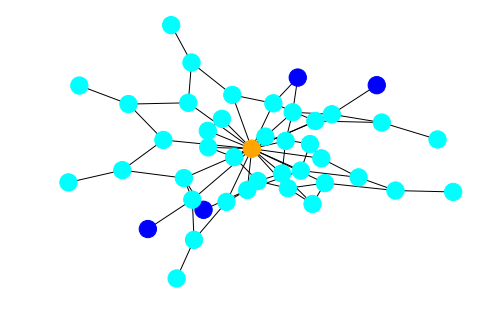

In [74]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt')


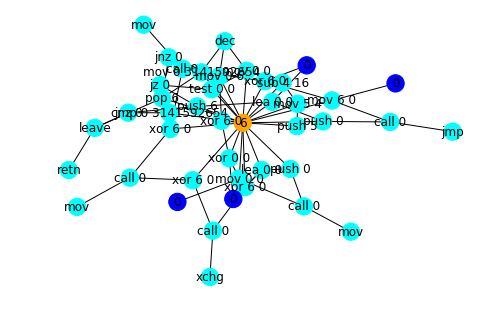

In [75]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt',
                  label='content')


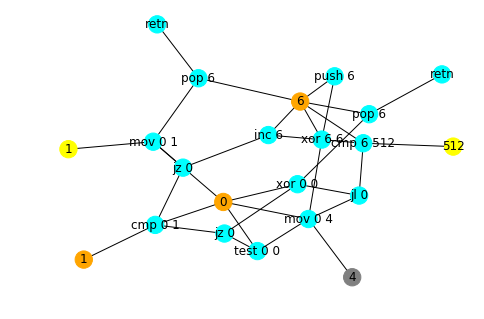

In [76]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'sub_452740_edges.txt',
                  label='content')


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


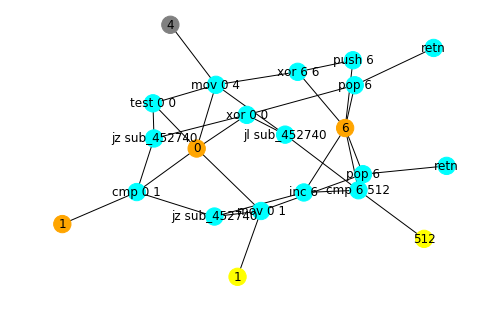

In [2]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'sub_452740_edges.txt',
                  label='content')

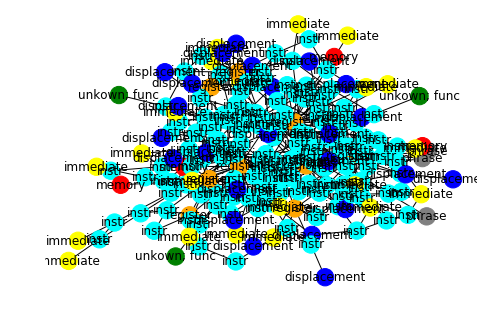

In [78]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt',
                  label='type')


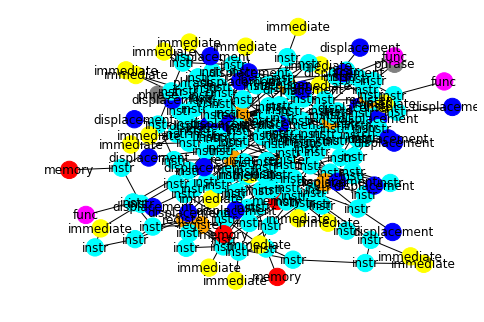

In [3]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt',
                  label='type')


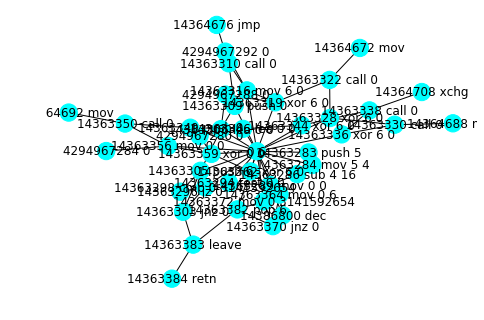

In [15]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt',
                  label='all')

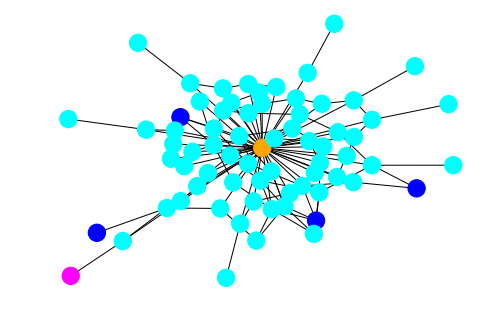

In [98]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB1B40_edges.txt')

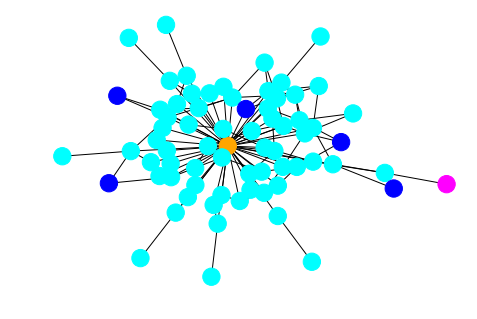

In [99]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB1BE0_edges.txt')

## Verification

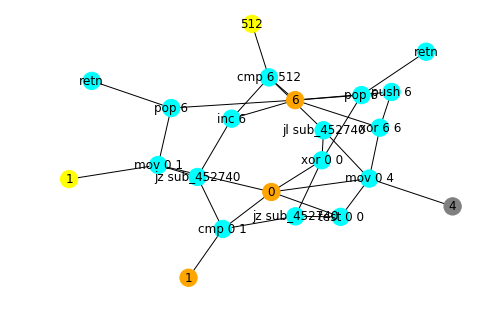

In [4]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'sub_452740_edges.txt',
                  label='content')

The assembler code in a block view:
![disassembler code blocks view](./verification/sub_452740.png)


In [5]:
g = readGraph(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'sub_452740_edges.txt')
i=0
for n1, n2, attr in g.edges(data=True): # unpacking
    print(n1, n2, attr) 
    i+=1
    #if i>3: break
i=0
for n in g.nodes(data=True):
    print(n)
    i+=1
    if i>1: break

4532064 r6 {'type': 'register'}
4532064 4532065 {'type': 'instr'}
4532064 4532059 {'type': 'instr'}
r6 4532033 {'type': 'register'}
r6 4532046 {'type': 'register'}
r6 4532032 {'type': 'register'}
r6 4532057 {'type': 'register'}
r6 4532047 {'type': 'register'}
4532053 4532035 {'type': 'unkown'}
4532053 4532047 {'type': 'instr'}
4532053 4532055 {'type': 'instr'}
4532035 4532033 {'type': 'instr'}
4532035 4532038 {'type': 'instr'}
4532035 r0 {'type': 'register'}
4532035 p4 {'type': 'phrase'}
4532033 4532032 {'type': 'instr'}
4532057 4532058 {'type': 'instr'}
4532057 4532055 {'type': 'instr'}
4532042 r1 {'type': 'register'}
4532042 r0 {'type': 'register'}
4532042 4532040 {'type': 'instr'}
4532042 4532044 {'type': 'instr'}
r0 4532055 {'type': 'register'}
r0 4532059 {'type': 'register'}
r0 4532038 {'type': 'register'}
4532040 4532038 {'type': 'instr'}
4532040 4532055 {'type': 'unkown'}
4532044 4532059 {'type': 'unkown'}
4532044 4532046 {'type': 'instr'}
4532059 im1 {'type': 'immediate'}
45320

In [12]:
g = readGraph(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'sub_452740_edges.txt')
sortednodes = [ node for node in g.nodes(data=True)]
s = sorted(sortednodes, key = lambda x: int(x[0]) if x[1]['type']=='instr' else 0)
i=0
for n in s:
    print(n)
    i+=1
    #if i>1: break

('r6', {'type': 'register', 'content': '6'})
('r1', {'type': 'register', 'content': '1'})
('r0', {'type': 'register', 'content': '0'})
('im1', {'type': 'immediate', 'content': '1'})
('p[edx+esi*4]', {'type': 'phrase', 'content': '[edx+esi*4]'})
('im512', {'type': 'immediate', 'content': '512'})
('4532032', {'type': 'instr', 'content': 'push 6'})
('4532033', {'type': 'instr', 'content': 'xor 6 6'})
('4532035', {'type': 'instr', 'content': 'mov 0 [edx+esi*4]'})
('4532038', {'type': 'instr', 'content': 'test 0 0'})
('4532040', {'type': 'instr', 'content': 'jz sub_452740'})
('4532042', {'type': 'instr', 'content': 'cmp 0 1'})
('4532044', {'type': 'instr', 'content': 'jz sub_452740'})
('4532046', {'type': 'instr', 'content': 'inc 6'})
('4532047', {'type': 'instr', 'content': 'cmp 6 512'})
('4532053', {'type': 'instr', 'content': 'jl sub_452740'})
('4532055', {'type': 'instr', 'content': 'xor 0 0'})
('4532057', {'type': 'instr', 'content': 'pop 6'})
('4532058', {'type': 'instr', 'content': '

In [5]:
g = readGraph(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt')
sortednodes = [ node for node in g.nodes(data=True)]
s = sorted(sortednodes, key = lambda x: int(x[0]) if x[1]['type']=='instr' else 0)
i=0
for n in g.edges(data=True):
    print(n)
    i+=1
    #if i>1: break

('4580256', 'r1', {'type': 'register'})
('4580256', '4580261', {'type': 'instr'})
('4580256', 'im3756743572', {'type': 'immediate'})
('4580256', '4580253', {'type': 'instr'})
('r1', '4580345', {'type': 'register'})
('r1', '4580383', {'type': 'register'})
('r1', '4580483', {'type': 'register'})
('r1', '4580299', {'type': 'register'})
('r1', '4580202', {'type': 'register'})
('r1', '4580244', {'type': 'register'})
('r1', '4580388', {'type': 'register'})
('r1', '4580520', {'type': 'register'})
('r1', '4580478', {'type': 'register'})
('r1', '4580617', {'type': 'register'})
('r1', '4580490', {'type': 'register'})
('r1', '4580627', {'type': 'register'})
('r1', '4580451', {'type': 'register'})
('r1', '4580396', {'type': 'register'})
('r1', '4580376', {'type': 'register'})
('r1', '4580614', {'type': 'register'})
('r1', '4580224', {'type': 'register'})
('r1', '4580457', {'type': 'register'})
('r1', '4580386', {'type': 'register'})
('r1', '4580230', {'type': 'register'})
('r1', '4580517', {'type'

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


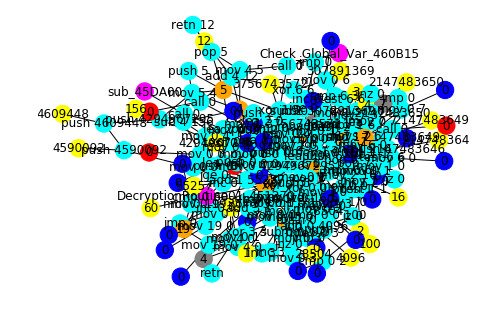

In [19]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt',
                  label='content')

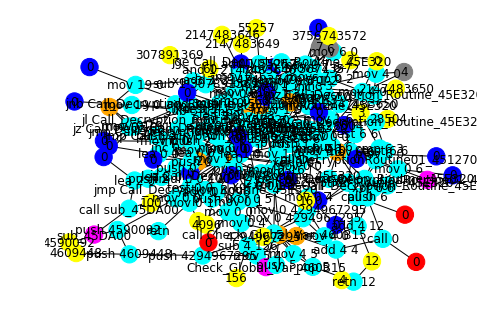

In [6]:
plotGraphFunction(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt',
                  label='content')

In [7]:
g = readGraph(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt')
sortednodes = [ node for node in g.nodes(data=True)]
i=0
for n in sortednodes:
    print(n)
    i+=1

('4580256', {'type': 'instr', 'content': 'mov 1 3756743572'})
('r1', {'type': 'register', 'content': '1'})
('4580194', {'type': 'instr', 'content': 'mov 0 6'})
('r6', {'type': 'register', 'content': '6'})
('4580438', {'type': 'instr', 'content': 'mov 0 3'})
('4580441', {'type': 'instr', 'content': 'mov 6 0'})
('4580150', {'type': 'instr', 'content': 'mov 0 4'})
('m0', {'type': 'memory', 'content': '0'})
('4580269', {'type': 'instr', 'content': 'mov 0 0'})
('4580275', {'type': 'instr', 'content': 'mov 7 3'})
('4580605', {'type': 'instr', 'content': 'mov 0 4294967295'})
('4580612', {'type': 'instr', 'content': 'xor 0 0'})
('4580558', {'type': 'instr', 'content': 'inc 3'})
('4580559', {'type': 'instr', 'content': 'mov 0 3'})
('4580149', {'type': 'instr', 'content': 'push 0'})
('4580213', {'type': 'instr', 'content': 'mov 0 0'})
('r0', {'type': 'register', 'content': '0'})
('4580157', {'type': 'instr', 'content': 'sub 4 156'})
('4580163', {'type': 'instr', 'content': 'mov 0 0'})
('4580138'

In [8]:
g = readGraph(folder ='./tmp/functions/raw/graphs01/',
                  filename = 'Call_Decryption_Routine_45E320_edges.txt')
sortednodes = [ node for node in g.nodes(data=True)]
s = sorted(sortednodes, key = lambda x: int(x[0]) if x[1]['type']=='instr' else 0)
i=0
for n in s:
    print(n)
    i+=1
    #if i>1: break

('r1', {'type': 'register', 'content': '1'})
('r6', {'type': 'register', 'content': '6'})
('m0', {'type': 'memory', 'content': '0'})
('r0', {'type': 'register', 'content': '0'})
('im4590092', {'type': 'immediate', 'content': '4590092'})
('im2', {'type': 'immediate', 'content': '2'})
('r4', {'type': 'register', 'content': '4'})
('r5', {'type': 'register', 'content': '5'})
('16', {'type': 'displacement', 'content': '0'})
('p6', {'type': 'phrase', 'content': '6'})
('im2147483646', {'type': 'immediate', 'content': '2147483646'})
('im100', {'type': 'immediate', 'content': '100'})
('p4', {'type': 'phrase', 'content': '4'})
('r3', {'type': 'register', 'content': '3'})
('im12', {'type': 'immediate', 'content': '12'})
('im4', {'type': 'immediate', 'content': '4'})
('4294967140', {'type': 'displacement', 'content': '0'})
('4294967136', {'type': 'displacement', 'content': '0'})
('r2', {'type': 'register', 'content': '2'})
('4294967272', {'type': 'displacement', 'content': '0'})
('4294967236', {'t

##  PyTorch Geometric importing tests

The graphs are imported into PyTorch Geometric to verify correctness and feasability. At the end a toy model is trained on some of the graphs to distinguish between network usage and no networks usage

In [1]:
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import time
import pickle
from torch_geometric.data import InMemoryDataset
import numpy as np
import traceback
import random
from numpy.random import choice
import pandas as pd
import os


        

def createDataset(x, edge_index):
    """
        Creates a PyTorch Geometric Dataset
        from a torch tensor (node features) x
        and an edge_index (adjacency list in the form
        [[n1, n1, n1, n2, n2, n3], [n1, n3, n2, n3, n1, n1]]
        for the edges (n1,n1), (n1,n3), (n1,n2), (n2, n3), (n2, n1)
        and (n3, n1)
    """
    return Data(x=x, edge_index=edge_index)
    

def createDatasetFromNX(g, xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        
        node features -> to one-hot-encoding
            - type (string)
            - content
                - reg number string -> to int
                - displacement number string -> to int?
                - memory/ other string -> to what?
                
    """
    # get edge list
    edges = g.edges
    edge_list_1 = []
    edge_list_2 = []
    for e in edges:
        # node id must be an int
        edge_list_1.append(int(e[0])) 
        edge_list_2.append(int(e[1]))
        if undirected:
            edge_list_1.append(int(e[1])) 
            edge_list_2.append(int(e[0]))
            
        
    edge_index = torch.tensor([ edge_list_1,
                                edge_list_2], dtype=torch.long)
    
    # create single 1 feature for each node
    n = xlen
    x = [[1.0] for i in range(n)]
    x = torch.tensor(x, dtype=torch.float)
    
    return createDataset(x, edge_index)
                         
def createDatasetFromNXwithTarget(g,y,xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        with node features (called target and represented by y )
        
        PENDING:
            - appepnd many Datas to the dataset
    """
    dataset =  createDatasetFromNX(g,xlen, undirected)
    y = torch.FloatTensor(y)
    dataset.y = y 
    return dataset


def createPyGDataset(folder):
    # read folder
    # and create g for each pair of files
    # transform this g into a Data() and put into a list
    g_list = []
    #g_class = []
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            # and create g for each pair of files
            filename = os.path.join(root, name)
            if filename.find('_edges') > -1:
                
                # extract class from name? 
                y = 0
                if filename.lower().find('http')>-1 or \
                   filename.lower().find('network')>-1 or \
                   filename.lower().find('send')>-1:
                    #g_class.append(1)
                    y = 1
                #else:
                #    g_class.append(0)
                
                # generate the nx and PyG graph
                try:
                    g = readGraph('',filename)
                    xlen = len(g.nodes())
                    G = createDatasetFromNXwithTarget(g,y,xlen,undirected=True)
                    g_list.append(G)
                except:
                    print(" Problem with "+filename)
                    
            
    
    # create a dataset
    data, slices = InMemoryDataset.collate(None, g_list) # hacky way
    torch.save((data, slices), 'dataset.pt')


In [70]:
createPyGDataset('./plugin/malw01_2019-04-04_17-52-13/') # it apparently worked
# now I need to implement the dataset class and load it and verify it works
# then next step is to implement the features translation to one-hot-encoding
# finally train a toy model (select some functions from a reversed or from a libc module?..)

##  PyTorch Geometric Dataset

In [2]:
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import time
import pickle
from torch_geometric.data import InMemoryDataset
import numpy as np
import traceback
import random
from numpy.random import choice
import pandas as pd
import os


import networkx as nx
import json
import matplotlib.pyplot as plt

def readGraph(folder, filename):
    # read nodes, edges and  edge attributes
    g = nx.read_edgelist(folder+filename)
    # read node attributes
    with open(folder+filename.replace('edges','nodes'),'r') as f:
        for line in f.readlines():
            tokens = line.split("{")
            nodeid = tokens[0][:-1]
            #print(nodeid)
            #print(tokens[1])
            attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
            #print(nodeid)
            #print(attr_dict)
            for k,v in attr_dict.items():
                g.node[nodeid][k] = v
                
    return g

def prepareLabelDict(g, attr):
    label_dict = {}
    for node in g.nodes():
        if attr == 'all':
            label_dict[node]=node + " " + \
                             g.node[node]['content']
        else:
            label_dict[node]=g.node[node][attr]
    return label_dict

def plotGraph(g, label=None):
    
    # color plot
    attrs={}
    palette = ['cyan', 'orange','yellow',
               'red','blue', 'grey',
               'magenta','green','black',   
               'pink',]
    types =['instr','register','immediate','memory',
        'displacement','phrase','func','unknown']
    
    for node in g.nodes():
        #if 'type' in g.node[node].keys():
        #    i = types.index(g.node[node]['type'])
        #else:
        if 'type' in g.node[node].keys():
            if g.node[node]['type'] in types:
                i = types.index(g.node[node]['type'])
            else:
                i=len(types)-1
                for j in types:
                    if g.node[node]['type'].startswith(j):
                        i = types.index(j)
        else:
            i=len(palette)-1
        attrs[node]={'color':palette[ i % len(palette)]}

    nx.set_node_attributes(g, attrs)
    colors = nx.get_node_attributes(g, 'color')
    if label:
        
        label_dict= prepareLabelDict(g,attr=label)
        nx.draw(g, 
            node_color=colors.values(),
            labels=label_dict,
            with_labels = True  )
    #nx.draw_circular(g, node_color=colors.values())
    #plt.draw()
    else:
        nx.draw(g, 
            node_color=colors.values())
    
def plotGraphFunction(folder, filename, label=None):
    g = readGraph(folder, filename)
    plotGraph(g,label)
        
class FunctionsDataset(InMemoryDataset):
    node_translation = {}
    nodeidmax = -1
    instr_types = ['instr','register','immediate','memory',
        'displacement','phrase','func','unknown']
    x86_instr_set = [ i.lower() for i in ['AAA', 'AAD', 'AAM', 'AAS', 'ADC', 'ADCX', 'ADD', 
                     'ADDPD', 'ADDPS', 'ADDSD', 'ADDSS', 'ADDSUBPD', 
                     'ADDSUBPS', 'ADOX', 'AESDEC', 'AESDECLAST', 'AESENC',
                     'AESENCLAST', 'AESIMC', 'AESKEYGENASSIST', 'AND', 'ANDN', 
                     'ANDNPD', 'ANDNPS', 'ANDPD', 'ANDPS', 'ARPL', 'BEXTR', 
                     'BLENDPD', 'BLENDPS', 'BLENDVPD', 'BLENDVPS', 'BLSI', 
                     'BLSMSK', 'BLSR', 'BNDCL', 'BNDCN', 'BNDCU', 'BNDLDX', 
                     'BNDMK', 'BNDMOV', 'BNDSTX', 'BOUND', 'BSF', 'BSR', 'BSWAP', 'BT', 'BTC', 'BTR', 'BTS', 'BZHI', 'CALL', 'CBW', 'CDQ', 'CDQE', 'CLAC', 'CLC', 'CLD', 'CLDEMOTE', 'CLFLUSH', 'CLFLUSHOPT', 'CLI', 'CLTS', 'CLWB', 'CMC', 'CMOVcc', 'CMP', 'CMPPD', 'CMPPS', 'CMPS', 'CMPSB', 'CMPSD', 'CMPSQ', 'CMPSS', 'CMPSW', 'CMPXCHG', 'COMISD', 'COMISS', 'CPUID', 'CQO', 'CWD', 'CWDE', 'DAA', 'DAS', 'DEC', 'DIV', 'DIVPD', 'DIVPS', 'DIVSD', 'DIVSS', 'DPPD', 'DPPS', 'EMMS', 'ENTER', 'EXTRACTPS', 'FABS', 'FADD', 'FADDP', 'FBLD', 'FBSTP', 'FCHS', 'FCLEX', 'FCMOVcc', 'FCOM', 'FCOMI', 'FCOMIP', 'FCOMP', 'FCOMPP', 'FCOS', 'FDECSTP', 'FDIV', 'FDIVP', 'FDIVR', 'FDIVRP', 'FFREE', 'FIADD', 'FICOM', 'FICOMP', 'FIDIV', 'FIDIVR', 'FILD', 'FIMUL', 'FINCSTP', 'FINIT', 'FIST', 'FISTP', 'FISTTP', 'FISUB', 'FISUBR', 'FLD', 'FLDCW', 'FLDENV', 'FLDPI', 'FLDZ', 'FMUL', 'FMULP', 'FNCLEX', 'FNINIT', 'FNOP', 'FNSAVE', 'FNSTCW', 'FNSTENV', 'FNSTSW', 'FPATAN', 'FPREM', 'FPTAN', 'FRNDINT', 'FRSTOR', 'FSAVE', 'FSCALE', 'FSIN', 'FSINCOS', 'FSQRT', 'FST', 'FSTCW', 'FSTENV', 'FSTP', 'FSTSW', 'FSUB', 'FSUBP', 'FSUBR', 'FSUBRP', 'FTST', 'FUCOM', 'FUCOMI', 'FUCOMIP', 'FUCOMP', 'FUCOMPP', 'FWAIT', 'FXAM', 'FXCH', 'FXRSTOR', 'FXSAVE', 'FXTRACT', 'HADDPD', 'HADDPS', 'HLT', 'HSUBPD', 'HSUBPS', 'IDIV', 'IMUL', 'IN', 'INC', 'INS', 'INSB', 'INSD', 'INSERTPS', 'INSW', 'INTO', 'INVD', 'INVLPG', 'INVPCID', 'IRET', 'IRETD', 'JMP', 'Jcc', 'KADDB', 'KADDD', 'KADDQ', 'KADDW', 'KANDB', 'KANDD', 'KANDNB', 'KANDND', 'KANDNQ', 'KANDNW', 'KANDQ', 'KANDW', 'KMOVB', 'KMOVD', 'KMOVQ', 'KMOVW', 'KNOTB', 'KNOTD', 'KNOTQ', 'KNOTW', 'KORB', 'KORD', 'KORQ', 'KORTESTB', 'KORTESTD', 'KORTESTQ', 'KORTESTW', 'KORW', 'KSHIFTLB', 'KSHIFTLD', 'KSHIFTLQ', 'KSHIFTLW', 'KSHIFTRB', 'KSHIFTRD', 'KSHIFTRQ', 'KSHIFTRW', 'KTESTB', 'KTESTD', 'KTESTQ', 'KTESTW', 'KUNPCKBW', 'KUNPCKDQ', 'KUNPCKWD', 'KXNORB', 'KXNORD', 'KXNORQ', 'KXNORW', 'KXORB', 'KXORD', 'KXORQ', 'KXORW', 'LAHF', 'LAR', 'LDDQU', 'LDMXCSR', 'LDS', 'LEA', 'LEAVE', 'LES', 'LFENCE', 'LFS', 'LGDT', 'LGS', 'LIDT', 'LLDT', 'LMSW', 'LOCK', 'LODS', 'LODSB', 'LODSD', 'LODSQ', 'LODSW', 'LOOP', 'LOOPcc', 'LSL', 'LSS', 'LTR', 'LZCNT', 'MASKMOVDQU', 'MASKMOVQ', 'MAXPD', 'MAXPS', 'MAXSD', 'MAXSS', 'MFENCE', 'MINPD', 'MINPS', 'MINSD', 'MINSS', 'MONITOR', 'MOV', 'MOVAPD', 'MOVAPS', 'MOVBE', 'MOVD', 'MOVDDUP', 'MOVDIRI', 'MOVDQA', 'MOVDQU', 'MOVHLPS', 'MOVHPD', 'MOVHPS', 'MOVLHPS', 'MOVLPD', 'MOVLPS', 'MOVMSKPD', 'MOVMSKPS', 'MOVNTDQ', 'MOVNTDQA', 'MOVNTI', 'MOVNTPD', 'MOVNTPS', 'MOVNTQ', 'MOVQ', 'MOVS', 'MOVSB', 'MOVSD', 'MOVSHDUP', 'MOVSLDUP', 'MOVSQ', 'MOVSS', 'MOVSW', 'MOVSX', 'MOVSXD', 'MOVUPD', 'MOVUPS', 'MOVZX', 'MPSADBW', 'MUL', 'MULPD', 'MULPS', 'MULSD', 'MULSS', 'MULX', 'MWAIT', 'NEG', 'NOP', 'NOT', 'OR', 'ORPD', 'ORPS', 'OUT', 'OUTS', 'OUTSB', 'OUTSD', 'OUTSW', 'PABSB', 'PABSD', 'PABSQ', 'PABSW', 'PACKSSDW', 'PACKSSWB', 'PACKUSDW', 'PACKUSWB', 'PADDB', 'PADDD', 'PADDQ', 'PADDSB', 'PADDSW', 'PADDUSB', 'PADDUSW', 'PADDW', 'PALIGNR', 'PAND', 'PANDN', 'PAUSE', 'PAVGB', 'PAVGW', 'PBLENDVB', 'PBLENDW', 'PCLMULQDQ', 'PCMPEQB', 'PCMPEQD', 'PCMPEQQ', 'PCMPEQW', 'PCMPESTRI', 'PCMPESTRM', 'PCMPGTB', 'PCMPGTD', 'PCMPGTQ', 'PCMPGTW', 'PCMPISTRI', 'PCMPISTRM', 'PDEP', 'PEXT', 'PEXTRB', 'PEXTRD', 'PEXTRQ', 'PEXTRW', 'PHADDD', 'PHADDSW', 'PHADDW', 'PHMINPOSUW', 'PHSUBD', 'PHSUBSW', 'PHSUBW', 'PINSRB', 'PINSRD', 'PINSRQ', 'PINSRW', 'PMADDUBSW', 'PMADDWD', 'PMAXSB', 'PMAXSD', 'PMAXSQ', 'PMAXSW', 'PMAXUB', 'PMAXUD', 'PMAXUQ', 'PMAXUW', 'PMINSB', 'PMINSD', 'PMINSQ', 'PMINSW', 'PMINUB', 'PMINUD', 'PMINUQ', 'PMINUW', 'PMOVMSKB', 'PMOVSX', 'PMOVZX', 'PMULDQ', 'PMULHRSW', 'PMULHUW', 'PMULHW', 'PMULLD', 'PMULLQ', 'PMULLW', 'PMULUDQ', 'POP', 'POPA', 'POPAD', 'POPCNT', 'POPF', 'POPFD', 'POPFQ', 'POR', 'PREFETCHW', 'PREFETCHh', 'PSADBW', 'PSHUFB', 'PSHUFD', 'PSHUFHW', 'PSHUFLW', 'PSHUFW', 'PSIGNB', 'PSIGND', 'PSIGNW', 'PSLLD', 'PSLLDQ', 'PSLLQ', 'PSLLW', 'PSRAD', 'PSRAQ', 'PSRAW', 'PSRLD', 'PSRLDQ', 'PSRLQ', 'PSRLW', 'PSUBB', 'PSUBD', 'PSUBQ', 'PSUBSB', 'PSUBSW', 'PSUBUSB', 'PSUBUSW', 'PSUBW', 'PTEST', 'PTWRITE', 'PUNPCKHBW', 'PUNPCKHDQ', 'PUNPCKHQDQ', 'PUNPCKHWD', 'PUNPCKLBW', 'PUNPCKLDQ', 'PUNPCKLQDQ', 'PUNPCKLWD', 'PUSH', 'PUSHA', 'PUSHAD', 'PUSHF', 'PUSHFD', 'PUSHFQ', 'PXOR', 'RCL', 'RCPPS', 'RCPSS', 'RCR', 'RDFSBASE', 'RDGSBASE', 'RDMSR', 'RDPID', 'RDPKRU', 'RDPMC', 'RDRAND', 'RDSEED', 'RDTSC', 'RDTSCP', 'REP', 'REPE', 'REPNE', 'REPNZ', 'REPZ', 'RET', 'ROL', 'ROR', 'RORX', 'ROUNDPD', 'ROUNDPS', 'ROUNDSD', 'ROUNDSS', 'RSM', 'RSQRTPS', 'RSQRTSS', 'SAHF', 'SAL', 'SAR', 'SARX', 'SBB', 'SCAS', 'SCASB', 'SCASD', 'SCASW', 'SETcc', 'SFENCE', 'SGDT', 'SHL', 'SHLD', 'SHLX', 'SHR', 'SHRD', 'SHRX', 'SHUFPD', 'SHUFPS', 'SIDT', 'SLDT', 'SMSW', 'SQRTPD', 'SQRTPS', 'SQRTSD', 'SQRTSS', 'STAC', 'STC', 'STD', 'STI', 'STMXCSR', 'STOS', 'STOSB', 'STOSD', 'STOSQ', 'STOSW', 'STR', 'SUB', 'SUBPD', 'SUBPS', 'SUBSD', 'SUBSS', 'SWAPGS', 'SYSCALL', 'SYSENTER', 'SYSEXIT', 'SYSRET', 'TEST', 'TPAUSE', 'TZCNT', 'UCOMISD', 'UCOMISS', 'UD', 'UMONITOR', 'UMWAIT', 'UNPCKHPD', 'UNPCKHPS', 'UNPCKLPD', 'UNPCKLPS', 'VALIGND', 'VALIGNQ', 'VBLENDMPD', 'VBLENDMPS', 'VBROADCAST', 'VCOMPRESSPD', 'VCOMPRESSPS', 'VDBPSADBW', 'VERR', 'VERW', 'VEXPANDPD', 'VEXPANDPS', 'VFIXUPIMMPD', 'VFIXUPIMMPS', 'VFIXUPIMMSD', 'VFIXUPIMMSS', 'VFPCLASSPD', 'VFPCLASSPS', 'VFPCLASSSD', 'VFPCLASSSS', 'VGATHERDPD', 'VGATHERDPS', 'VGATHERQPD', 'VGATHERQPS', 'VGETEXPPD', 'VGETEXPPS', 'VGETEXPSD', 'VGETEXPSS', 'VGETMANTPD', 'VGETMANTPS', 'VGETMANTSD', 'VGETMANTSS', 'VMASKMOV', 'VPBLENDD', 'VPBLENDMB', 'VPBLENDMD', 'VPBLENDMQ', 'VPBLENDMW', 'VPBROADCAST', 'VPBROADCASTB', 'VPBROADCASTD', 'VPBROADCASTM', 'VPBROADCASTQ', 'VPBROADCASTW', 'VPCMPB', 'VPCMPD', 'VPCMPQ', 'VPCMPUB', 'VPCMPUD', 'VPCMPUQ', 'VPCMPUW', 'VPCMPW', 'VPCOMPRESSD', 'VPCOMPRESSQ', 'VPCONFLICTD', 'VPCONFLICTQ', 'VPERMB', 'VPERMD', 'VPERMILPD', 'VPERMILPS', 'VPERMPD', 'VPERMPS', 'VPERMQ', 'VPERMW', 'VPEXPANDD', 'VPEXPANDQ', 'VPGATHERDD', 'VPGATHERDQ', 'VPGATHERQD', 'VPGATHERQQ', 'VPLZCNTD', 'VPLZCNTQ', 'VPMASKMOV', 'VPMOVDB', 'VPMOVDW', 'VPMOVQB', 'VPMOVQD', 'VPMOVQW', 'VPMOVSDB', 'VPMOVSDW', 'VPMOVSQB', 'VPMOVSQD', 'VPMOVSQW', 'VPMOVSWB', 'VPMOVUSDB', 'VPMOVUSDW', 'VPMOVUSQB', 'VPMOVUSQD', 'VPMOVUSQW', 'VPMOVUSWB', 'VPMOVWB', 'VPMULTISHIFTQB', 'VPROLD', 'VPROLQ', 'VPROLVD', 'VPROLVQ', 'VPRORD', 'VPRORQ', 'VPRORVD', 'VPRORVQ', 'VPSCATTERDD', 'VPSCATTERDQ', 'VPSCATTERQD', 'VPSCATTERQQ', 'VPSLLVD', 'VPSLLVQ', 'VPSLLVW', 'VPSRAVD', 'VPSRAVQ', 'VPSRAVW', 'VPSRLVD', 'VPSRLVQ', 'VPSRLVW', 'VPTERNLOGD', 'VPTERNLOGQ', 'VPTESTMB', 'VPTESTMD', 'VPTESTMQ', 'VPTESTMW', 'VPTESTNMB', 'VPTESTNMD', 'VPTESTNMQ', 'VPTESTNMW', 'VRANGEPD', 'VRANGEPS', 'VRANGESD', 'VRANGESS', 'VREDUCEPD', 'VREDUCEPS', 'VREDUCESD', 'VREDUCESS', 'VRNDSCALEPD', 'VRNDSCALEPS', 'VRNDSCALESD', 'VRNDSCALESS', 'VSCALEFPD', 'VSCALEFPS', 'VSCALEFSD', 'VSCALEFSS', 'VSCATTERDPD', 'VSCATTERDPS', 'VSCATTERQPD', 'VSCATTERQPS', 'VTESTPD', 'VTESTPS', 'VZEROALL', 'VZEROUPPER', 'WAIT', 'WBINVD', 'WRFSBASE', 'WRGSBASE', 'WRMSR', 'WRPKRU', 'XABORT', 'XACQUIRE', 'XADD', 'XBEGIN', 'XCHG', 'XEND', 'XGETBV', 'XLAT', 'XLATB', 'XOR', 'XORPD', 'XORPS', 'XRELEASE', 'XRSTOR', 'XRSTORS', 'XSAVE', 'XSAVEC', 'XSAVEOPT', 'XSAVES', 'XSETBV', 'XTEST', 'EACCEPT', 'EACCEPTCOPY', 'EADD', 'EAUG', 'EBLOCK', 'ECREATE', 'EDBGRD', 'EDBGWR', 'EDECVIRTCHILD', 'EENTER', 'EEXIT', 'EEXTEND', 'EGETKEY', 'EINCVIRTCHILD', 'EINIT', 'ELBUC', 'ELDB', 'ELDBC', 'ELDU', 'EMODPE', 'EMODPR', 'EMODT', 'ENCLS', 'ENCLU', 'ENCLV', 'EPA', 'ERDINFO', 'EREMOVE', 'EREPORT', 'ERESUME', 'ESETCONTEXT', 'ETRACK', 'ETRACKC', 'EWB', 'INVEPT', 'INVVPID', 'VMCALL', 'VMCLEAR', 'VMFUNC', 'VMLAUNCH', 'VMPTRLD', 'VMPTRST', 'VMREAD', 
                     'VMRESUME', 'VMWRITE', 'VMXOFF', 'VMXON']]
    
    def __init__(self, root, transform=None, pre_transform=None):
        super(FunctionsDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])


    @property
    def raw_file_names(self):
        return ['graphs01']

    @property
    def processed_file_names(self):
        return ['functions.pt']

    def download(self):
        # Download to `self.raw_dir`.
        # this step is not implemented. You need to manually
        # copy the folders that contain the output of the plugin
        # inside the raw folder
        print("Not implemented. Missing folders with graph files in txt for Nx format, for each program to be included in the dataset")
        

    def process(self):
        # Read data into huge `Data` list.
        print(" FunctionsDataset: process()")
        print("self.processed_paths",self.processed_paths)
        print("self.root",self.root)
        print("self.raw_dir",self.raw_dir)
        print("self.raw_file_names",self.raw_file_names)
        print("self.raw_paths",self.raw_paths)
        #print(" now for the instance attributes")
        #for elem in dir(self):
        #    print(elem)
        print()
        
        data_list = self.readDatasets(self.raw_paths)
        print()
        print("Finished reading dataset")
        print()

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            
        print("After pre filter-transform, ", len(data_list))
    
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
          
            
    def readDatasets(self, folders):
        dataset_list = []
        for folder in folders:
            dataset = self.readDataset(folder)
            dataset_list.extend(dataset)
        return dataset_list
        
    def readDataset(self, folder):    
        g_list = []
        #g_class = []
        for root, dirs, files in os.walk(folder, topdown=False):
            for name in files:
                # and create g for each pair of files
                filename = os.path.join(root, name)
                if filename.find('_edges') > -1:

                    # extract class from name? 
                    y = [0]
                    if filename.lower().find('http')>-1 or \
                       filename.lower().find('network')>-1 or \
                       filename.lower().find('send')>-1:
                        #g_class.append(1)
                        y = [1]
                    #else:
                    #    g_class.append(0)

                    # generate the nx and PyG graph
                    try:
                        g = readGraph('',filename)
                        xlen = len(g.nodes())
                        G = self.createGraphFromNXwithTarget(g,y,xlen,undirected=True)
                        g_list.append(G)
                    except Exception as err:
                        print(" Problem with "+filename)
                        traceback.print_exc()
        return g_list


    def createGraph(self, x, edge_index):
        """
            Creates a PyTorch Geometric Dataset
            from a torch tensor (node features) x
            and an edge_index (adjacency list in the form
            [[n1, n1, n1, n2, n2, n3], [n1, n3, n2, n3, n1, n1]]
            for the edges (n1,n1), (n1,n3), (n1,n2), (n2, n3), (n2, n1)
            and (n3, n1)
        """
        return Data(x=x, edge_index=edge_index)


    def resetNodeTranslation(self):
        self.nodeidmax = -1
        self.node_translation = {}
        
    def translateNodeIds(self,nodeid,g):
        """
            Pre:
                nodeid is a string (usually string but could be anything)
            Post:
                if nodeid has already been translated, it will return the previous translation.
                otherwise it will create a new autoincremented integer and return it and save it
                
                new version:
                    now each type has it's own dictionary with autoincrement
                    at the end, they are appended, and id's are added with an offset
        """
        
        
        # get the type of the node
        node_type = ''
        if 'type' in g.node[nodeid].keys():
            node_type = g.node[nodeid]['type']
            
        if node_type not in self.node_translation.keys():
            self.node_translation[node_type]={'_maxid': -1}
        
        if nodeid in self.node_translation[node_type].keys():
            return self.node_translation[node_type][nodeid], node_type
        else:
            self.node_translation[node_type]['_maxid']+=1
            
            nid = self.node_translation[node_type]['_maxid']
            self.node_translation[node_type][nodeid] = nid
            return nid, node_type
        
    def one_hot_nodetype(self, gnode, typelist = None):
        if typelist is None:
            typelist = self.instr_types
        result = [0 for i in range(len(typelist)) ]
        typestring = ''
        if 'type' in gnode.keys():
            typestring = gnode['type']
            try:
                index_type = typelist.index(typestring)
                result[index_type]=1
            except:
                print("one_hot_nodetype, type not found: ", typestring)
        
        return result
    
    def one_hot_instruction(self, gnode):
        """
            Extracted the listing from wikipedia (may be incomplete)
            
            if node is not an instruction, try will pass and return all 0s
        """
        result = [0 for i in range(len(self.x86_instr_set)) ]
        try:
            index_mnemonic = self.x86_instr_set.index(gnode['content'])
            #print(" instruction ", gnode['content']," as ",index_mnemonic)
            result[index_mnemonic] = 1
        except:
            pass
        return result
    
    def update_edge_list(self, edge_list_1, n1, node_type):
        
        if node_type not in edge_list_1.keys():
            edge_list_1[node_type]=[n1]
            
        else:
            edge_list_1[node_type].append(n1)
            
        return edge_list_1
    
    def merge_edge_list(self, edge_list):
        """
            pre: edge_list a dict of lists of ints
        """
        result_list = []
        previous_max_id = 0
        for k,vlist in edge_list.items():
            result_list.extend([ elemid + previous_max_id for elemid in vlist])
            previous_max_id = max(vlist) + previous_max_id
            
        return result_list
    
    def createGraphFromNX(self, g, xlen, undirected=True):
        """
            Creates a PyTorch Geometric dataset
            from a NetworkX graph

            node features -> to one-hot-encoding
                - type (string)
                - content
                    - reg number string -> to int
                    - displacement number string -> to int?
                    - memory/ other string -> to what?

        """
        # get edge list
        edges = g.edges
        edge_list_1 = {}
        edge_list_2 = {}
        self.resetNodeTranslation()
        for e in edges:
            # node id must be an int
            
            # make nodeid by type
            # then merge the list
            n1, node_type1 = self.translateNodeIds(e[0],g)
            n2, node_type2 = self.translateNodeIds(e[1],g)
            
            self.update_edge_list(edge_list_1, n1, node_type1)
            self.update_edge_list(edge_list_2, n2, node_type2)
            
            # edge features?
            
            if undirected:
                self.update_edge_list(edge_list_2, n1, node_type1)
                self.update_edge_list(edge_list_1, n2, node_type2)
                # edge features?
            


        edge_list_1 = self.merge_edge_list(edge_list_1)
        edge_list_2 = self.merge_edge_list(edge_list_2)
        edge_index = torch.tensor([ edge_list_1,
                                    edge_list_2], dtype=torch.long)

        # features
        # use e[0] and e[1] original memoray address values as a feature
        # add the rest of the features: type, content, ...
        
        # starting point: 
        #    g.node[node]={
        #      'type': 'register' ,
        #       'content' : integer}
        #   and node as a memaddr
        # result:
        #  x [ type_as_one-hot-enc, int(content), int(node)]
        n = xlen
        x = {}
        for node in g.nodes():
            nodeid = self.translateNodeIds(node, g)
            memaddr = int(node)
            instr_type = self.one_hot_nodetype(g.node[node])
            
            if 'type' in g.node[node].keys() and \
               g.node[node]['type'] != 'instr':
                try:
                    content_not_instr = int(g.node[node]['content'])
                except:
                    content_not_instr = 0
                
            else:
                content_not_instr = 0
                
            content_instr = self.one_hot_instruction(g.node[node])
            
            
            x[nodeid] = [memaddr, content_not_instr]
            #print("content_instr: ",content_instr)
            x[nodeid].extend(content_instr)
            #print("instr_type: ", instr_type)
            x[nodeid].extend(instr_type)
            
        # now transform into a sorted list
        x = sorted([(k,v) for k,v in x.items()], key = lambda x: x[0] )
        x = [ e[1] for e in x]
        #print(x[:2])
        x = torch.tensor(x, dtype=torch.float)

        return self.createGraph(x, edge_index)

    def createGraphFromNXwithTarget(self,g,y,xlen, undirected=True):
        """
            Creates a PyTorch Geometric dataset
            from a NetworkX graph
            with node features (called target and represented by y )

            PENDING:
                - appepnd many Datas to the dataset
        """
        dataset =  self.createGraphFromNX(g,xlen, undirected)
        y = torch.LongTensor(y)
        dataset.y = y 
        return dataset
    
   

In [3]:
dataset = FunctionsDataset(root='./tmp/functions')
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_features)


340
2
801


In [4]:
for i in range(10):
    print(dataset[i])

Data(edge_index=[2, 204], x=[97, 801], y=[1])
Data(edge_index=[2, 50], x=[25, 801], y=[1])
Data(edge_index=[2, 2], x=[2, 801], y=[1])
Data(edge_index=[2, 72], x=[35, 801], y=[1])
Data(edge_index=[2, 1054], x=[475, 801], y=[1])
Data(edge_index=[2, 148], x=[72, 801], y=[1])
Data(edge_index=[2, 468], x=[217, 801], y=[1])
Data(edge_index=[2, 626], x=[290, 801], y=[1])
Data(edge_index=[2, 346], x=[165, 801], y=[1])
Data(edge_index=[2, 322], x=[149, 801], y=[1])


In [5]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)
for graph in loader:
    print(graph)
    print(graph.edge_index.max().item(),graph.edge_index.min().item()  )
    print(graph.edge_index[0][:10])
    print(graph.x[:10])
    print(graph.x.size())
    print()

Batch(batch=[391], edge_index=[2, 870], x=[391, 801], y=[2])
385 0
tensor([0, 0, 1, 1, 1, 2, 2, 2, 2, 3])
tensor([[4.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.6133e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [5.2000e+01, 8.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.6134e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.0000e+00, 6.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0400e+02, 1.0000e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
torch.Size([391, 801])

Batch(batch=[395], edge_index=[2, 1146], x=[395, 801], y=[2])
392 0
tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 3])
tensor([[4.2950e+09, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5771e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e

400 0
tensor([0, 1, 2, 2, 3, 4, 3, 3, 3, 5])
tensor([[4.5909e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5918e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.3200e+02, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
torch.Size([407, 801])

Batch(batch=[460], edge_index=[2, 978], x=[460, 801], y=[2])
453 0
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3])
tensor([[1.6000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5518e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.0000e+00, 8.0000e+00, 0.

271 0
tensor([0, 0, 1, 1, 2, 3, 4, 5, 6, 7])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5904e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2950e+09, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.5904e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2950e+09, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5904e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
torch.Size([277, 801])

Batch(batch=[129], edge_index=[2, 290], x=[129, 801], y=[2])
123 0
tensor([0, 0, 1, 1, 2, 3, 4, 5, 6, 7])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5708e+06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [4.5708e+06, 0.0000e+00, 0.

##  Training a toy model

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
#from torch_geometric.nn.conv.gated_graph_conv import GatedGraphConv
from torch_geometric.nn.glob.glob import global_mean_pool, global_add_pool
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer
from torch_geometric.datasets import TUDataset, QM9, QM7b, PPI, Planetoid, KarateClub

from TFM_function_renaming import *
from TFM_graph_classification_models import *

dataset = FunctionsDataset(root='./tmp/functions')
dataset = dataset.shuffle()
k = 3
n = len(dataset)
print(" n:",n," k folds=",k)
train_dataset, test_dataset = balancedDatasetSplit_slice(dataset, prop=0.8)
print("Datasets balancing: ")
printDatasetBalance(dataset )
printDatasetBalance(train_dataset )
printDatasetBalance(test_dataset )
print()


global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_list21 = []
for modelclass in [GGNN1]:
    for d1 in [900]:  # num features = 801 -> for ggnn d1 > num_features so 900
        for d2 in [20]:
            for aggr_type in ['mean','add']:
                for epochs in [50]:
                    for num_layers in [2]:
                        for lr in [0.01]:
                            for wd in [5e-4]:
                                model_list21.append(
                                    {
                                    'model': modelclass,
                                    'epochs': epochs,
                                    'kwargs':{'d1': d1,'d2': d2,'num_layers':num_layers, 
                                              'aggr_type':aggr_type}, 
                                    'learning_rate': lr, 'weight_decay':wd, 
                                    'batch_size': 2},
                                )

modelsdict1 = modelSelection(model_list21,k, train_dataset, balanced=False)
reportModelSelectionResult(modelsdict1)

 n: 340  k folds= 3
Datasets balancing: 
{0: 328, 1: 12}
{0: 262, 1: 9}
{0: 66, 1: 3}

 trained model:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 50  val loss= 0.07569909592469533  val accuracy= 1.0  val microF1= 0.9666666666666667  val macroF1= 0.4915254237288135
Problem training model GGNN1
 trained model:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 50  val loss= 0.0  val accuracy= 0.0  val microF1= 0.0  val macroF1= 0.0


Traceback (most recent call last):
  File "/media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/TFM_function_renaming.py", line 979, in modelSelection
    val_loss_model(model, loader_val, optimizer, val_history)
  File "/media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/TFM_function_renaming.py", line 705, in val_loss_model
    return val_loss_model_GGNN(model, loader, optimizer, val_history)
  File "/media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/TFM_function_renaming.py", line 633, in val_loss_model_GGNN
    measures = F1Score(total_acc, total_gt)
  File "/media/disk/home/pau/Projectes/GNN-MThesis/src/function_renaming/TFM_function_renaming.py", line 175, in F1Score
    preddict[pred[i]].append(i)
KeyError: 3



 selected model from loss:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 50 0.0 0.0 0.0 0.0
 selected model from accuracy:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 50 0.07569909592469533 1.0 0.0 0.0
 selected model from microF1:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 50 0.07569909592469533 1.0 0.9666666666666667 0.4915254237288135
 selected model from macroF1:  GGNN1 {'d1': 900, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 50 0.07569909592469533 1.0 0.9666666666666667 0.4915254237288135
